# Heavy Equipment Case Study: Modeling

In [368]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.cross_validation import cross_val_score, KFold, train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns
%matplotlib inline

Our error metric is root mean squared logarithmic error, defined by the function below.

In [97]:
def rmsle(y_true, y_pred):
    return np.sqrt( ( (np.log(y_pred+1) - np.log(y_true+1))**2 ).sum() / float(len(y_pred)) )

### Loading the Data

In [225]:
df = pd.read_csv('data/train_cleaned.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df['datasource_132'] = df['datasource_132'].apply(lambda x: x.astype(int))

In [226]:
ylog = np.log(df['SalePrice']).values
y = df.pop('SalePrice').values
X = df.values

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, train_size=0.8)

## Baseline Model (Mean)

The most simple model is one where we predict the price to be the mean.

In [217]:
y_pred = np.zeros(len(y_test))
y_mean = y_train.mean()
for i,v in enumerate(y_test):
    y_pred[i] = y_mean

In [218]:
rmsle(y_test, y_pred)

0.73273039488334835

### Linear Regression

In [228]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [230]:
y_pred = lr.predict(X_test)
rmsle(y_test, y_pred)

nan

In [231]:
(y_pred<0).sum()

388

We're getting an NaN for our rmsle metric, because some of the predictions are negative values. This means our model is currently off by quite a bit. Let's do some tuning with regularization to see if we can remove some features. 

### Lasso Regression (L1 norm)

In [232]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

alphas = np.logspace(-2,4,10)
betas = []
for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X_train_scaled, y_train)
    betas.append(lasso.coef_)

In [233]:
betas_t = np.array(betas).T

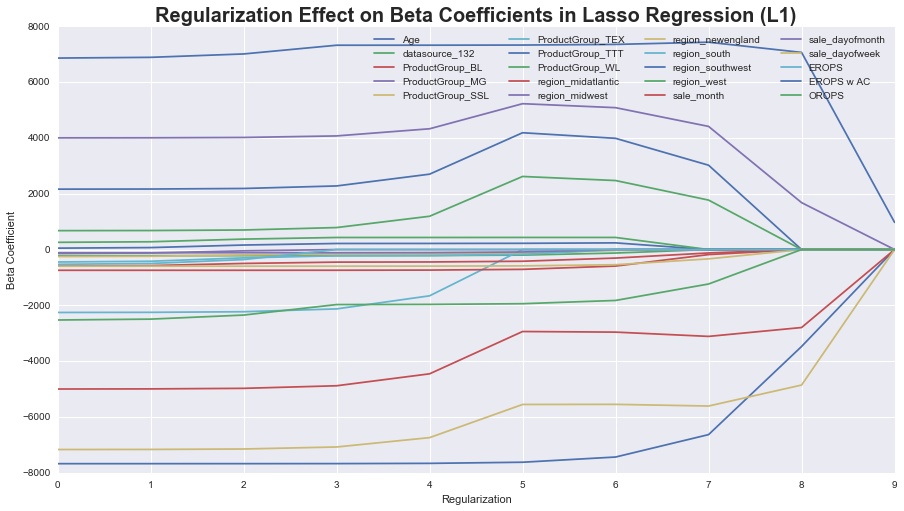

In [234]:
fig = plt.figure(figsize=(15,8))
for i,b in enumerate(betas_t):
    plt.plot(b, label=df.columns.values[i])
plt.legend(ncol=4)
plt.title('Regularization Effect on Beta Coefficients in Lasso Regression (L1)', fontdict={'fontsize':20, 'fontweight':'bold'})
plt.xlabel('Regularization')
plt.ylabel('Beta Coefficient')

Since we used the L1 norm for regularizing our linear regression model, a number of coefficients shrink to 0 after a certain point (a behavior unachievable in Ridge regression [L2 norm]). Let's choose an arbitrary cutoff point in the graph above, say where at the 7th regularization point (unitless in the graph).

In [345]:
feature_idx = np.argsort(abs(betas[7]))[-((abs(betas[7]) > 0.01).sum()):]
feature_idx

array([ 8, 14, 16, 19,  7,  6,  2,  3,  4,  0, 18])

In [331]:
df.columns[feature_idx]

Index([u'region_midatlantic', u'sale_month', u'sale_dayofweek', u'OROPS',
       u'ProductGroup_WL', u'ProductGroup_TTT', u'ProductGroup_BL',
       u'ProductGroup_MG', u'ProductGroup_SSL', u'Age', u'EROPS w AC'],
      dtype='object')

Let's try using running the model again using just these features.

In [325]:
lr = LinearRegression()
lr.fit(X_train_scaled[:,feature_idx], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [326]:
y_pred = lr.predict(scaler.fit_transform(X_test[:,feature_idx]))

In [328]:
lr.coef_

array([ -486.75675988,  -625.71257353,  -671.01384594, -1980.96780005,
        2693.60377576,  4230.11449124, -2866.49327594,  5279.20542115,
       -5499.83514466, -7600.65085981,  7382.95053843])

In [329]:
(y_pred<0).sum()

409

There are still negative values in our prediction. Let's try removing the second-last predictor since it's the largest in the negative.

In [347]:
feature_idx = np.append(feature_idx[:-2], feature_idx[-1:])

In [348]:
lr = Lasso()
lr.fit(X_train_scaled[:,feature_idx], y_train)
y_pred = lr.predict(scaler.fit_transform(X_test[:,feature_idx]))

In [353]:
rmsle(y_test, y_pred)

0.56315509971140565

We achieved a 0.56 error, which is better than the 0.73 error from the baseline model.

### Random Forests Regressor

Let's first try a Random Forests Regressor using all our features.

In [372]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [373]:
y_pred = rf.predict(X_test)
rmsle(y_test, y_pred)

0.47542544979980728

Let's now retry it with just the top n features we identified when running our linear model.

In [358]:
rf = RandomForestRegressor()
rf.fit(X_train[:,feature_idx], y_train)
y_pred = rf.predict(X_test[:,feature_idx])
rmsle(y_test, y_pred)

0.54872058004834035

Not great... let's add Age back in (recall that we removed it earlier).

In [363]:
rf = RandomForestRegressor()
rf.fit(X_train[:,np.append(feature_idx,0)], y_train)
y_pred = rf.predict(X_test[:,np.append(feature_idx,0)])
rmsle(y_test, y_pred)

0.49709887229489269

That's not bad. We can grid search between the two feature sets to see which is better.

### Boosting Regressors

In [366]:
ada = AdaBoostRegressor()
ada.fit(X_train[:,np.append(feature_idx,0)], y_train)
y_pred = ada.predict(X_test[:,np.append(feature_idx,0)])
rmsle(y_test, y_pred)

0.61972798858641609

In [367]:
gb = GradientBoostingRegressor()
gb.fit(X_train[:,np.append(feature_idx,0)], y_train)
y_pred = gb.predict(X_test[:,np.append(feature_idx,0)])
rmsle(y_test, y_pred)

0.49648969119049563

### GridSearch

Let's Grid Search through our Random Forest Regressor (using all the features), since that did the best.

In [381]:
params = {'n_estimators': [5,50,100],
         'min_samples_split': [20,500,2000],
         'min_samples_leaf': [10,250,1000]}
gs = GridSearchCV(RandomForestRegressor(max_features='sqrt'), param_grid=params, cv=KFold(len(X_train),shuffle=True))

In [382]:
gs.fit(X_train, y_train)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=320900, n_folds=3, shuffle=True, random_state=None),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 50, 100], 'min_samples_split': [20, 500, 2000], 'min_samples_leaf': [10, 250, 1000]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [384]:
gs.best_params_

{'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 100}

In [386]:
rf = RandomForestRegressor(min_samples_leaf=10, min_samples_split=20, n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rmsle(y_test, y_pred)

0.4604300022605875

Based on this initial attempt at grid search, our best estimator has these tuned hyperparameters:
- No of estimators: 100
- Minimum samples per split: 20
- Minimum samples per leaf: 10

## Reflection & Thoughts

Looking back at this project, I initially performed some Exploratory Data Analysis (EDA) to better understand the data and to explore potential feature-engineering solutions. We had 52 features to start with, and we ended up with 20 or so. While we feature engineered a couple of new columns, we also lost more than half of the features that we initially had. Even so, after trying different models, our most successful model was a Random Forest Regressor with tuned hyperparameters, achieving a RMSLE error of 0.46 on the validation set, a sizeable improvement from the baseline model's (just using the mean) 0.73 score.

If I had more time, I would explore the following:

- Investigate MachineHoursCurrentMeter and UsageBand. These could hold useful information for how much a machine's usage affects its selling price.
- Explore the relationship between historical prices for similar models (utilizing ModelID, fiModelDesc, or fiBasemodel)
- Cross validate different imputation techniques for age outliers (mean, median etc.)
- Explore other ways to impute the missing values for the columns we removed (e.g. regress on other features)
- If we manage to impute all our missing values, we still end up with 50+ feature. Perhaps perform some clustering technique (K-Means, hierarchical, PCA, or some matrix factorization (NMF, SVD) to reduce the dimensionality of our space.
- Perform more granular depth on grid search, and try fine-tune the other models (GradientBoostingRegressor)
- Fit a separate model for models with Age > a certain threshold, since the scatter plot of Age vs SalePrice shows two separate clusters.
- Extract information from the unstructured text